# Spotify Data Analysis
## Data Cleaning
### Downloading My Spotify Data

First, I needed to request my spotify streaming history, which can be done [here](https://www.spotify.com/us/account/privacy/). There will then be an email sent to confirm the data request. It can take up to 30 days for Spotify to prepare the data for download, when it will then be sent in an email with a link to the download. This will download a folder named `my_spotify_data`, which contains multiple JSON files. The files of interest are named `StreamingHistory0.json` and `StreamingHistory1.json`. These files contain the Spotify streaming history of the user for the past year. Each file contains 10000 instances, so there will be more of these files depending on how many songs have been listened to in the last year. These files can be read into a pandas `DataFrame` with the following code.

In [1]:
import pandas as pd

streaming_history_0_df = pd.read_json("StreamingHistory0.json")
streaming_history_1_df = pd.read_json("StreamingHistory1.json")

# print(streaming_history_0_df)
# print(streaming_history_1_df)

### Concatenating the Datasets
The two `DataFrames` can be concatenated using `pd.concat()` because they contain the same columns. This will add the second dataset below the first dataset. Ignoring index will make the index continue through the combined dataset, instead of starting over when the second dataset begins.

In [2]:
spotify_df = pd.concat([streaming_history_0_df, streaming_history_1_df], ignore_index=True)

print(spotify_df)

                endTime     artistName  \
0      2019-12-12 23:06    Johnny Nash   
1      2019-12-13 02:37    Johnny Nash   
2      2019-12-13 02:40    Johnny Nash   
3      2019-12-13 05:27    Johnny Nash   
4      2019-12-13 05:30    Johnny Nash   
...                 ...            ...   
13352  2020-12-12 07:11     Lee Morgan   
13353  2020-12-12 07:12  Wayne Shorter   
13354  2020-12-12 07:23  Wayne Shorter   
13355  2020-12-12 10:09  Elvis Presley   
13356  2020-12-12 10:14             U2   

                                               trackName  msPlayed  
0                                  I Can See Clearly Now     59372  
1                                  I Can See Clearly Now    163012  
2                                  I Can See Clearly Now    140863  
3                                  I Can See Clearly Now    163575  
4                                  I Can See Clearly Now    162653  
...                                                  ...       ...  
13352  The S

### Downloading My Location History
First, I needed to request my location data from [Google Takeout](https://takeout.google.com/). This is downloaded as a JSON file, in either multiple files separated by month, or as one large file. I'll be using the large file for this project. These files can be read into a pandas `DataFrame` with the following code.

In [3]:
import json
location_dict = json.load(open("Location History.json"))
location_df = pd.DataFrame(location_dict["locations"])

We are only interested in the time, latitude, and longitude columns. The rest of the columns have too many missing values, and they can just be deleted using the follow code.

In [4]:
location_df = location_df.drop(columns=["activity", "accuracy", "velocity", "heading", "altitude", "verticalAccuracy"])

We need to check if there are any missing values in the dataframe. This is done with the following code:

In [5]:
print("Missing Values in timestampMs:", location_df["timestampMs"].isnull().values.any())
print("Missing Values in latitudeE7: ", location_df["latitudeE7"].isnull().values.any())
print("Missing Values in longitudeE7:", location_df["longitudeE7"].isnull().values.any())
print("Missing values in location_df:", location_df.isnull().values.any())

Missing Values in timestampMs: False
Missing Values in latitudeE7:  False
Missing Values in longitudeE7: False
Missing values in location_df: False


There are no missing values in the dataset, so we do not need to deal with them. If there were any, it would be best to drop the instance.

The time column for the spotify data is in the format YYYY-MM-DD HH:MM in UTC time, but the location history time is formatted in unix time in milliseconds. Unix time is the number of milliseconds after January 1st, 1970. We need to convert the location history time to YYYY-MM-DD HH:MM format. We can do this using the `datetime` library.

In [6]:
print(spotify_df["endTime"][0])

2019-12-12 23:06


In [7]:
import datetime
location_df["timestamp"] = location_df["timestampMs"].apply(int).divide(1000) # divides all timstamps by 1000 so they are not in ms
location_df["datetime"] = (location_df["timestamp"].apply(datetime.datetime.utcfromtimestamp).dt.strftime("%Y-%m-%d %H:%M"))

print(location_df["datetime"][0])

2015-07-03 01:30


We only need part of the location history, as it goes back to 2016, and streaming history starts at 10-28-2019. We can find the index of the first row of `location_df` that starts after this date.

In [8]:
for i in range(len(location_df["datetime"])):
    if location_df["datetime"][i] > spotify_df["endTime"][0]:
        print(location_df["datetime"][i])
        print(i)
        print(location_df["datetime"][i-1])
        print(i-1)
        break

2019-12-12 23:08
927228
2019-12-12 23:06
927227


This shows that the index of the first row of `location_df` that is in the timeline of the spotify data is 895852. We can use this to cut off the part of the dataset that we don't need.

In [9]:
location_df = location_df[895852:][:]

### Concatenating Streaming History and Location History
We need to concatenate the streaming history and location history. We can do this by 

In [10]:
# make a column in spotify_df that shows the closest time in location_df
def FindClosestTime(spotify_date):
    for time in location_df["datetime"]:
        if time > spotify_date:
            return time

spotify_df["datetime"] = spotify_df["endTime"].apply(FindClosestTime)

We can now concatenate based on "closest time" and "datetime". There was a problem joining them because some rows in location_df have matching values in "datetime", which creates duplicate columns when they are joined. This can be fixed using .drop_duplicates(), so that the "datetime" column in location_df doesn't have any duplicates.

In [11]:
combined_df = spotify_df.set_index("datetime").join(location_df.drop_duplicates(subset=['datetime']).set_index("datetime"), how='left', on='datetime')
# print(combined_df)

We need to check for missing values. There are missing values, at the end of the spotify data where the location history ends but the spotify data continues. There is about a day of data where this is true. We can drop all of the rows with missing values using .dropna().

In [12]:
print("Missing values in combined_df:", combined_df.isnull().values.any())
combined_df = combined_df.dropna()

Missing values in combined_df: True


In [13]:
combined_df["time"] = combined_df.index
combined_df["index"] = range(len(combined_df))
combined_df = combined_df.set_index('index')

Save to a csv to save time, because running the above code takes a long time.

In [14]:
combined_df.to_csv("combined.csv")

In [15]:
combined_df = pd.read_csv("combined.csv")

### Spotify API
We can use the [spotify API](https://developer.spotify.com/) to get more data on the songs. I am interested in the tempo of each song. We can use the code we wrote in class to do this.

In [60]:
import requests
import json 
import base64

# TODO: move these into a file/environment variable external to the code
client_ID = "e4e9b57363d9471e9ffdf7ebf70818bf"
client_secret = "2d1efcd217104009b91d263f7458ac67"

auth_endpoint = "https://accounts.spotify.com/api/token"
search_API_endpoint = "https://api.spotify.com/v1/search"

# get access token to use for authentication with search api
def get_access_token():
    # from Spotify docs:
    # Required: Base 64 encoded string that contains the client ID and client secret key. 
    # The field must have the format: 
    # Authorization: Basic *<base64 encoded client_id:client_secret>*
    message = client_ID + ":" + client_secret
    message_bytes = message.encode("ascii")
    base64_bytes = base64.b64encode(message_bytes)
    encoded_client_details = base64_bytes.decode("ascii")
    
    headers = {"Authorization": "Basic " + encoded_client_details}              
    body = {"grant_type": "client_credentials"}
    response = requests.post(url=auth_endpoint, headers=headers, data=body)
    json_object = json.loads(response.text)
    return json_object["access_token"]
    
# make the request using requests module
# need to send the access token via request headers
def make_request(access_token, full_url):
    headers = {"Accept": "application/json", 
               "Content-Type": "application/json", 
               "Authorization": "Bearer " + access_token}

    response = requests.get(url=full_url, headers=headers)
    json_object = json.loads(response.text)

    return json_object

# create request url, make request, return JSON response
def search_request(access_token, search_term, search_type):
    search_term = requests.utils.quote(search_term)
    search_type = requests.utils.quote(search_type)
    url = search_API_endpoint + "?q=" + search_term
    url += "&type=" + search_type
    url += "&limit=1"
    json_obj = make_request(access_token, url)
    return json_obj

def get_id(track_name):
    json_obj = search_request(access_token, track_name, "track")
    return json_obj['tracks']['items'][0]['id']
    
def get_features(track_name):
    try:
        access_token = get_access_token()
        song_id = get_id(track_name)
        url = "https://api.spotify.com/v1/audio-features/" + song_id
        json_obj = make_request(access_token, url)
        return json_obj
    except:
        return None

This code can be applied to all of the instances in combined_df to create a new column "duration" using `.apply`. This code is slow, so we will save combined_df to a csv so this doesn't need to run every time.

In [91]:
index_names = combined_df[ combined_df['artistName'] == "Monday Morning Podcast" ].index 
combined_df = combined_df.drop(index_names)

index_names = combined_df[ combined_df['artistName'] == "Barefoot to Emmaus"].index 
combined_df = combined_df.drop(index_names)

index_names = combined_df[ combined_df['artistName'] == "The Bill Bert Podcast"].index 
combined_df = combined_df.drop(index_names)

combined_df.to_csv("removed_podcasts.csv")

In [92]:
combined_df = pd.read_csv("removed_podcasts.csv")
combined_df.index = range(len(combined_df))

Reset the dictionaries. This is separated so that when the next block crashes, the dictionaries it is reading to retain their values.

In [ ]:
# duration_dict = {}
# tempo_dict = {}
# acousticness_dict = {}
# danceability_dict = {}
# energy_dict = {}
# instrumentalness_dict = {}
# liveness_dict = {}

Request data from the Spotify API. We are requesting duration_ms, tempo, acousticness, danceability, energy, instrumentalness, adn liveness. We can request this data by first finding the song_id using `get_id(track_name)`, which is using the search function on the Spotify API to find the id of a song. This is limited to This id can then be used 

In [192]:
for i in combined_df["trackName"][12915:].index:
    track_name = combined_df["trackName"][i]
    access_token = get_access_token()
    song_id = get_id(track_name)
    url = "https://api.spotify.com/v1/audio-features/" + song_id
    json_obj = make_request(access_token, url)
    print(i, track_name, type(track_name))
#     print(json_obj)
    json_obj = get_features(track_name)
#     print(json_obj['duration_ms'])
#     test_df["duration"][i] = json_obj['duration_ms']
#     test_df["tempo"][i] = json_obj['tempo']
    duration_dict[i] = json_obj["duration_ms"]
    tempo_dict[i] = json_obj["tempo"]
    acousticness_dict[i] = json_obj["acousticness"]
    danceability_dict[i] = json_obj["danceability"]
    energy_dict[i] = json_obj["energy"]
    instrumentalness_dict[i] = json_obj["instrumentalness"]
    liveness_dict[i] = json_obj["liveness"]

12915 Red Wine, Mistakes, Mythology <class 'str'>
12916 Posters <class 'str'>
12917 Girl, I Wanna Lay You Down <class 'str'>
12918 Rodeo Clowns <class 'str'>
12919 Cry, Cry, Cry <class 'str'>
12920 Talk Of The Town <class 'str'>
12921 At Or With Me <class 'str'>
12922 Spring Wind <class 'str'>
12923 Country Road - Live In Santa Barbara, California/2008 <class 'str'>
12924 Banana Pancakes <class 'str'>
12925 Sitting, Waiting, Wishing <class 'str'>
12926 Washing Dishes <class 'str'>
12927 Never Know <class 'str'>
12928 Constellations <class 'str'>
12929 Flake <class 'str'>
12930 Angel <class 'str'>
12931 If I Had Eyes <class 'str'>
12932 You Remind Me Of You <class 'str'>
12933 Never Fade <class 'str'>
12934 No Other Way <class 'str'>
12935 Do You Remember <class 'str'>
12936 My Mind Is For Sale <class 'str'>
12937 Better Together <class 'str'>
12938 Sunsets For Somebody Else <class 'str'>
12939 Upside Down <class 'str'>
12940 Fragments - From The Film "The Smog Of The Sea" <class 'str'>

In [711]:
combined_df["duration"] = pd.Series(duration_dict)
combined_df["tempo"] = pd.Series(tempo_dict)
combined_df["acousticness"] = pd.Series(acousticness_dict)
combined_df["danceability"] = pd.Series(danceability_dict)
combined_df["energy"] = pd.Series(energy_dict)
combined_df["instrumentalness"] = pd.Series(instrumentalness_dict)
combined_df["liveness"] = pd.Series(liveness_dict)

In [199]:
# print(combined_df["duration"])
combined_df.to_csv("added_spotify_api.csv")

We can use the duration column to create a new column, "skipped". This column will be no if the song was played all the way through, and yes if it was not. This column will be used for classification. 

In [200]:
import numpy as np
combined_df['skipped'] = np.where(combined_df['duration']-10000 >= combined_df['msPlayed'], 'yes', 'no')

### Finding City Names from Longitude/Latitude
First we need to convert the long/lat data into a more useful form. It can be rounded and then divided by 10^7.

In [204]:
combined_df["latitude"] = combined_df["latitudeE7"].round(-7).divide(10000000)
combined_df["longitude"] = combined_df["longitudeE7"].round(-7).divide(10000000)

In [207]:
combined_df["city"] = np.where(combined_df["longitude"] < -119, 'Seattle', 'Spokane')

In [208]:
print("Missing values in combined_df:", combined_df.isnull().values.any())

Missing values in location_df: False


Now that the data cleaning is done, we need to save the DataFrame to a csv, we'll call this "cleaned_data.csv". This csv will be loaded in order to save time.

In [206]:
# combined_df.to_csv("cleaned_data.csv")

In [209]:
cleaned_df = pd.read_csv("cleaned_data.csv")

In [279]:
print(cleaned_df)

                endTime       artistName                 trackName  msPlayed  \
0      2019-12-12 23:06      Johnny Nash     I Can See Clearly Now     59372   
1      2019-12-13 02:37      Johnny Nash     I Can See Clearly Now    163012   
2      2019-12-13 02:40      Johnny Nash     I Can See Clearly Now    140863   
3      2019-12-13 05:27      Johnny Nash     I Can See Clearly Now    163575   
4      2019-12-13 05:30      Johnny Nash     I Can See Clearly Now    162653   
...                 ...              ...                       ...       ...   
13306  2020-12-10 10:38  Seth MacFarlane   Baby, It's Cold Outside     19596   
13307  2020-12-10 10:41  Seth MacFarlane  Have You Met Miss Jones?    150695   
13308  2020-12-10 10:41  Seth MacFarlane             But Beautiful     35610   
13309  2020-12-10 10:41  Seth MacFarlane             But Beautiful         0   
13310  2020-12-10 10:48       Lee Morgan       I Remember Clifford    428973   

       duration    tempo  acousticness 

## Creating Visual Representations
### Time Played Per Month Pie Chart
The first chart is a pie chart that shows the amount of time spent listening to music per month. This plot is created by grouping the `Dataframe` by the month in the endTime column, and finding the sum of msPlayed. The plot is then created by matplotlib using `plt.pie`. 

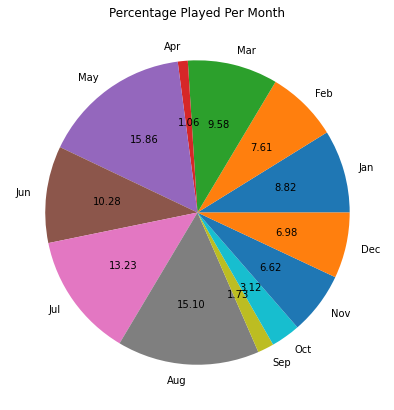

In [210]:
ms_played_dict = {}
month_dict = {"01":"Jan", "02":"Feb", "03":"Mar", "04":"Apr", "05":"May", "06":"Jun", "07":"Jul", "08":"Aug", "09":"Sep", "10":"Oct", "11":"Nov", "12":"Dec"}
for group_name, group in combined_df.groupby(combined_df.endTime.str[5:7]):
    ms_played = group.loc[:,'msPlayed'].sum()
    ms_played_dict[month_dict[group_name]] = ms_played
ms_played_ser = pd.Series(ms_played_dict)

from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))
plt.pie(ms_played_ser, labels=ms_played_ser.index, autopct='%.2f' )
plt.title("Percentage Played Per Month")
plt.show()

The chart shows that the month with the most listening activity was May, with 15.2% of all listening for the year, and that April was the month with the least activity, accounting for only 1.02% of listening. This chart shows that I listen to more music during the summer, with the highest four months being, May, June, July, and August.

### Most Played Songs
This is a bar chart which shows the top 10 most played songs, and shows the amount of times each was played. This was created using `.value_counts()`, which counts the amount of repeats and orders the series by the most played.

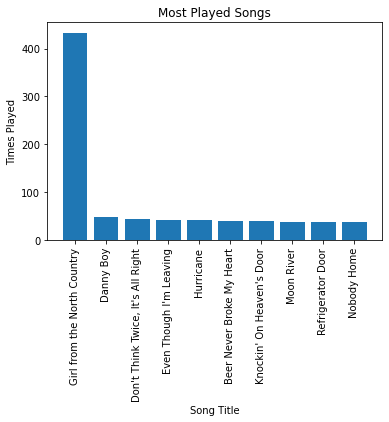

In [211]:
most_played = combined_df["trackName"].value_counts()

plt.figure()
plt.bar(most_played.iloc[0:10].index, height = most_played.iloc[0:10])
plt.xticks(rotation=90)
plt.title("Most Played Songs")
plt.ylabel("Times Played")
plt.xlabel("Song Title")
plt.show()

This chart shows that my top song was "Girl from the North Country", which I played over 400 times, about 3 times more than any other song. This is not what I would call my favorite song, but the reason that I played it so many times is because it is one of my favorite songs to play on guitar. This is the case for several other songs in this chart. I am curious to see if the songs that I know how to play are played more often than other songs.

### Most Played Artists

This is a similar chart to the last chart, except instead of trackName, its artistName.

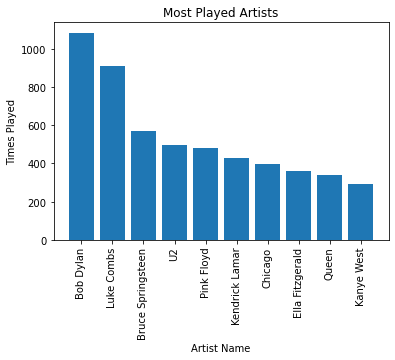

In [212]:
most_played = combined_df["artistName"].value_counts()
# print(most_played)

# print(most_played.iloc[0:10])
plt.figure()
# plt.bar(most_played.index, height=most_played)
plt.bar(most_played.iloc[0:10].index, height = most_played.iloc[0:10])
plt.xticks(rotation=90)
plt.title("Most Played Artists")
plt.ylabel("Times Played")
plt.xlabel("Artist Name")
plt.show()

This chart resembles the last chart, as most of the songs artists on the last chart are included in this chart. It also includes a heavy drop 
off between the most played and the rest.

### Seattle Energy vs. Spokane Energy
Energy is one of the features on the Spotify API, and represents the energy of the song. The below chart is a histogram of the energy of songs played in Seattle and songs played in Spokane.

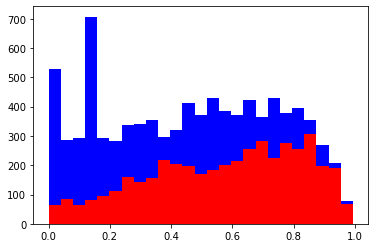

In [318]:
tempo_sea_ser = cleaned_df.groupby("city").get_group("Seattle")["energy"]
tempo_spo_ser = cleaned_df.groupby("city").get_group("Spokane")["energy"]

plt.figure()
plt.hist(tempo_sea_ser, bins=25, color='blue')
plt.hist(tempo_spo_ser, bins=25, color="r")
plt.show()

## Data Analysis
I am interested in whether I listen to different types of music in Spokane or Seattle. My lifestyle changes dramatically from Spokane to Seattle because I don't have school while I am in Seattle, and often listen to music with my brothers, who listen to different kinds of music than me. I want to know if the average tempo of my music changes with with these lifestlye changes. I predict that the average tempo of songs played in Seattle is faster than those played in Spokane, because in Spokane I normally listen to music while I am working on schoolwork, and I think that I play slower, more relaxing music while studying.

H0: $\mu_{tempo Seattle} \leq \mu_{tempo Spokane}$  
H1: $\mu_{tempo Seattle} > \mu_{tempo Spokane}$

$\alpha = 0.05$

This is a one-tail independent test, because the two samples contain different instances, and it is an inequality.

In [327]:
import scipy.stats as stats

tempo_seattle_ser = cleaned_df.groupby("city").get_group("Seattle")["tempo"]
tempo_spokane_ser = cleaned_df.groupby("city").get_group("Spokane")["tempo"]

t_computed, p_value = stats.ttest_ind(tempo_seattle_ser, tempo_spokane_ser)
print("t computed:", t_computed)
print("p value:", p_value /2) # one-tailed!

t computed: -5.4596929208585
p value: 2.4275491063061896e-08


Since p value < alpha, do not reject H0.

## Classification
The class we are predicting is "skipped". Which tells if the song was skipped before it was over. The values are "yes" and "no". "yes" means that the song was skipped, and "no" means that it was not. The stakeholders interested in these results would be me, Spotify, and record labels. I would be impacted by the results because it would allow me to predict what songs I will like. Spotify would be impacted because if they did a similar analysis on the rest of their listeners, they could find out what songs they should recommend. Record labels would want to know so that they could release songs that people would like.

We will do this using both kNN and a decision tree.
### KNN
First we will try to predict "skipped" using k nearest neighbors. We will do this using sklearn. The first step in doing this is to create a new `DataFrame` for the classification. We will need to scale some of the values, and we want to keep the values that are currently stored in cleaned_df. y is the attribute being classified, in this case, "skipped". x is the rest of the data, but we have removed the columns that aren't helpful. We are dropping "artistName", "trackName", and "skipped" because they are class labels. "msPlayed" needs to be dropped because it would be too easy to predict "skipped", because "skipped" is calculated off of "msPlayed". We are dropping "longitude" and "latitude" because they can be summarized better by "city".

In [615]:
y = cleaned_df["skipped"]
x = cleaned_df.drop(["artistName", "trackName", "msPlayed", "longitude", "latitude", "skipped"], axis=1)

Now we need to scale the data with a min max scale, meaning that the values go from 0 to 1, which will eliminate some attributes carrying more weight. We can do this using `MinMaxScaler()` from sklearn. A lot of the attributes are already scaled in this fashion, so we only need to do it for "endTime", "duration", "city", and "tempo". First we will do "duration" and "tempo".

In [616]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

x["duration"] = scaler.fit_transform(x["duration"].values.reshape(-1,1))
x["tempo"] = scaler.fit_transform(x["tempo"].values.reshape(-1,1))

Next we need to normalize the "endTime" column. We first need to convert it to unix time so that we can then scale it.

In [617]:
x["endTime"] = x["endTime"].apply(datetime.datetime.strptime, args=("%Y-%m-%d %H:%M",)).apply(datetime.datetime.timestamp)
x["endTime"] = scaler.fit_transform(x["endTime"].values.reshape(-1,1))

Finally we need to normalize the "city" column. Seattle will be 0, and Spokane will be 1.

In [618]:
x["city"] = np.where(x["city"] == 'Seattle', 0, 1)

Now that all of the columns are normalized, we can test kNN using the hold out method.

In [691]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0, stratify=y, test_size=0.25)

knn_clf = KNeighborsClassifier(n_neighbors=3, metric="euclidean")
knn_clf.fit(X_train, y_train)

y_predicted_knn = knn_clf.predict(X_test)
accuracy_knn = knn_clf.score(X_test, y_test)
print("kNN accuracy:",accuracy_knn)

# print(y_test.value_counts()[0]/len(y_test))

kNN accuracy: 0.7013221153846154


The accuracy is 70.1%. This is a slight improvement over always guessing "no", which would yield an accuracy of 68.6%. This is better than I expected the algorithm to be.

### Decision Tree
Now we are going to test with a decision tree. We can use the same DataFrame as before.

In [710]:
dt_clf = DecisionTreeClassifier(max_depth=12)
dt_clf.fit(X_train, y_train)

y_predicted_dt = dt_clf.predict(X_test)
accuracy_dt = dt_clf.score(X_test, y_test)
print("Decision Tree Accuracy:", accuracy_dt)

Decision Tree Accuracy: 0.7731370192307693


The decision tree has an accuracy of 77.3%. This is better than kNN. I am surprised that an algorithm is able to tell if I will skip a song with this high of an accuracy.

## Conclusion
Conclusion: Provide a brief conclusion of your project, including a short summary of the dataset you used (and any of its inherent challenges for classification), the classification approach you developed, your classifiers’ performance, and any ideas you have on ways to improve performance. Lastly, describe the potential impacts of your work (including ethical impacts) for the stakeholder’s you described in the introduction.

The dataset was very difficult to gather and clean, and most of my time was spent doing this. At the start of the semester, we were taught that data scientists spend most of their time cleaning data, and I probably should have expected that this would be true for me as well. Cleaning the data was very frustrating, because a lot of songs didn't work with the API. Gathering the data from the API took a really long time, because there are 13,000 instances, and each instance needed to request from the API three times, which makes ~40,000 requests from the API in total. This was the most difficult part of the project. I could have sped this up by requesting 10 data for 10 songs at a time, and by avoiding repeat songs. I had a lot of errors when I tried to do this, so I decided it would be easier to do it one at a time. In hindsight, I should have spent more time doing trying to do this, as it probably would have saved me time in the long run.

This impacts me by informing me more about my listening habits. It could impact how Spotify recommends me music, and could impact how record labels release music. Spotify and record labels could make more money by using machine learning, and I'm sure that they are already doing this. This could have ethical impacts because machine learning algorithms could be biased, and might favor certain songs or artists. This would make it very difficult for some artists to get into the industry, because if there songs weren't being recommended then nobody would hear their music.